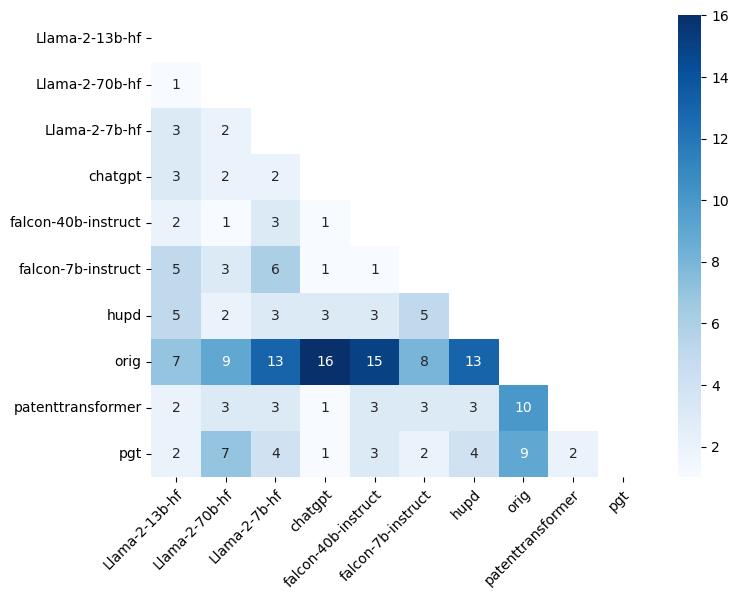

In [1]:
import json
import numpy as np
from collections import defaultdict


with open('./human_eval_c2a.json') as f:  annotations = json.load(f)
with open('./selected_pairs_c2a.jsonl') as f:  meta = [json.loads(line) for line in f]
meta_pairs = []
for meta_selection in meta:
    selections = list(meta_selection.values())[0]
    for pair in selections:
        meta_pairs.append(pair)
meta_pairs_annotated = meta_pairs[:len(annotations)]


# model frequency in selected pairs
model_freq = defaultdict(int)
for pair in meta_pairs:
    model1, model2 = pair
    model_freq[model1] += 1
    model_freq[model2] += 1
model_freq = dict(model_freq)


# create matrix of model pairs
model_names = list(model_freq.keys())
model_names = sorted(model_names)
model_pairs = np.zeros((len(model_names), len(model_names)))
for pair in meta_pairs:
    model1, model2 = pair
    model_pairs[model_names.index(model1), model_names.index(model2)] += 1
    model_pairs[model_names.index(model2), model_names.index(model1)] += 1


# plot the heatmap of model pairs, only show upper triangle of the matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(model_pairs, columns=model_names, index=model_names)
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 6))
sns.heatmap(df, mask=mask, annot=True, fmt='.0f', cmap='Blues')
# Adjust x-tick labels
plt.xticks(np.arange(len(model_names))+0.5, model_names, rotation=45, ha="right", rotation_mode='anchor')

plt.savefig('./figures/c2a_model1_model2', dpi=300)

In [3]:
import json

with open('./selected_pairs_c2a.jsonl') as f:  meta = [json.loads(line) for line in f]
meta_pairs = []
for meta_selection in meta:
    selections = list(meta_selection.values())[0]
    for pair in selections:
        meta_pairs.append(pair)
meta_pairs_annotated = meta_pairs[:len(annotations)]

# model frequency in selected pairs
model_freq = defaultdict(int)
for pair in meta_pairs:
    model1, model2 = pair
    model_freq[model1] += 1
    model_freq[model2] += 1
model_freq = dict(model_freq)

with open('./annotations/version3_c2a.json') as f:  annotations = json.load(f)

new_annotations = []
for annot in annotations:
    selected_annotations = []
    for la in annot["annotations"]:
        # if "zuo" in la["completed_by"]["email"].lower():
        selected_annotations.append(la)
    if len(selected_annotations) > 0:
        annot["annotations"] = [d["result"] for d in selected_annotations][0]
        annot["annotations"] = [a for a in annot["annotations"] if a["type"] != "labels"]
        new_annotations.append(annot["annotations"])
    else: # skipped or emply annotations
        annot["annotations"] = []
        new_annotations.append(annot["annotations"])

annotations = new_annotations            
# save annotations with indent=4
with open('./annotations/version3_c2a.txt', 'w') as f:
    for annotation in annotations:
        f.write(json.dumps(annotation))
        f.write('\n')

Error in annotation {'id': '7cXy_Yo7Ez', 'type': 'textarea', 'value': {'text': ['copy of claim1']}, 'origin': 'manual', 'to_name': 'answer1', 'from_name': 'comment1'} in pair ('falcon-7b-instruct', 'orig')
Error in annotation {'id': 'rlMzH933oY', 'type': 'textarea', 'value': {'text': ['copy of claims']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('orig', 'Llama-2-70b-hf')
Error in annotation {'id': '3GQo6qeA5U', 'type': 'textarea', 'value': {'text': ['copy of claim1']}, 'origin': 'manual', 'to_name': 'answer1', 'from_name': 'comment1'} in pair ('Llama-2-70b-hf', 'falcon-7b-instruct')
Error in annotation {'id': '-T4teLAp3Q', 'type': 'textarea', 'value': {'text': ['copy of claim1']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('Llama-2-7b-hf', 'Llama-2-13b-hf')
Error in annotation {'id': 'EQ7vAJ_Ism', 'type': 'textarea', 'value': {'text': ['copy of claim1']}, 'origin': 'manual', 'to_name': 'answer1', 'from_name': 'comment1'

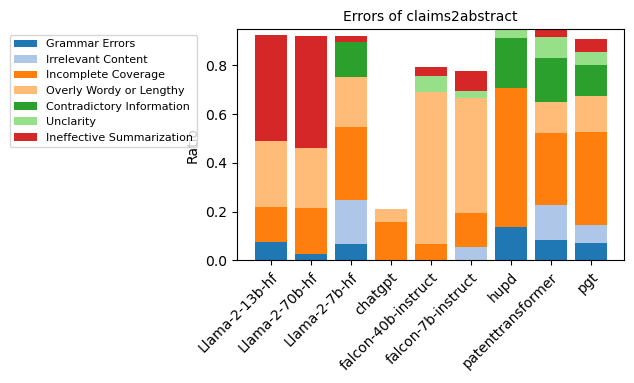

In [4]:
from collections import defaultdict

default_errors = ["Grammar Errors", "Irrelevant Content", "Incomplete Coverage", "Overly Wordy or Lengthy", "Contradictory Information", "Unclarity", "Other", "Correct"]
default_errors = {error: 0 for error in default_errors}

# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annotation in zip(meta_pairs_annotated, annotations):
    model_correct, model2_correct = True, True

    for annot in annotation:
        if annot["type"] == "pairwise":
            if annot["value"]["selected"] == "left": to_model = model1
            elif annot["value"]["selected"] == "right": to_model = model2
        elif annot["type"] == "choices":
            to_model = annot["to_name"]
            if annot["to_name"] == "answer1":
                to_model = model1
                model1_correct = False
            elif annot["to_name"] == "answer2":
                to_model = model2
                model2_correct = False
            for choice in annot["value"]["choices"]:
                errors[to_model][choice.split("(")[0].strip()] += 1
        else:
            print("Error in annotation", annot, "in pair", (model1, model2))
    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1


# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
errors = sorted(errors.items(), key=lambda x: x[0])
errors = [(model, {error: freq / sum(error_freq.values()) for error, freq in error_freq.items()}) for model, error_freq in errors if model != "orig"]

# change "Other" to "Ineffective Summarization"
for i, (model, error_freq) in enumerate(errors):
    if "Other" in error_freq:
        errors[i][1]["Ineffective Summarization"] = error_freq["Other"]
        errors[i][1].pop("Other")
        
############################################################################################################
# draw barchart of error ratio, remove "Correct" error
import matplotlib.pyplot as plt
import numpy as np

# Define the Tableau 20 color palette
tableau20 = [
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
]

# Fix size of the plot
plt.figure(figsize=(5, 3))

model_names, error_freqs = zip(*errors)
error_names = list(error_freqs[0].keys())

# Remove 'Correct' from error names for plotting
if 'Correct' in error_names:
    error_names.remove('Correct')

error_freqs = [[error_freq.get(error, 0) for error in error_names] for error_freq in error_freqs]
error_freqs = np.array(error_freqs)

bottom = np.zeros(len(model_names))
for i, error_name in enumerate(error_names):
    color = tableau20[i % len(tableau20)]  # Cycle through Tableau 20 colors
    plt.bar(model_names, error_freqs[:, i], bottom=bottom, label=error_name, color=color)
    bottom += error_freqs[:, i]

plt.xticks(rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Ratio")
plt.title("Errors of claims2abstract", fontsize=10)

# put legend outside of the plot on the upper left
plt.legend(bbox_to_anchor=(-0.6, 1), loc='upper left', ncol=1, fontsize=8)
plt.savefig('./figures/c2a_error_ratio', dpi=300)

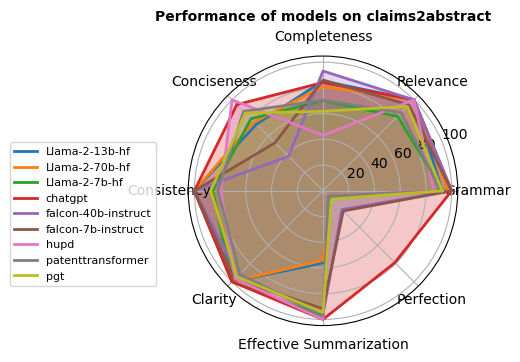

In [5]:
# calculate the number of times each model is selected
choices_with_models = defaultdict(int)
# calculate the number of times each model is compared with the original
freq_with_orig, choices_with_orig = defaultdict(int), defaultdict(int)

default_errors = ["Grammar Errors", "Irrelevant Content", "Incomplete Coverage", "Overly Wordy or Lengthy", "Contradictory Information", "Unclarity", "Other", "Correct"]
default_errors = {error: 0 for error in default_errors}

# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annotation in zip(meta_pairs_annotated, annotations):

    model_correct, model2_correct = True, True
    has_preference = False

    for annot in annotation:
        if annot["type"] == "pairwise":
            # if orig is in the comparison, add to choices_with_orig
            if "orig" in [model1, model2]:
                if model1 == "orig": 
                    freq_with_orig[model2] += 1
                    if annot["value"]["selected"] == "left": to_model = model1
                    elif annot["value"]["selected"] == "right": to_model = model2
                    choices_with_orig[to_model] += 1
                elif model2 == "orig": 
                    freq_with_orig[model1] += 1
                    if annot["value"]["selected"] == "left": to_model = model1
                    elif annot["value"]["selected"] == "right": to_model = model2
                    choices_with_orig[to_model] += 1
            # if orig is not in the comparison, add to choices
            else:
                if annot["value"]["selected"] == "left": to_model = model1
                elif annot["value"]["selected"] == "right": to_model = model2
                choices_with_models[to_model] += 1
            has_preference = True

        elif annot["type"] == "choices":
            to_model = annot["to_name"]
            if annot["to_name"] == "answer1":
                to_model = model1
                model1_correct = False
            elif annot["to_name"] == "answer2":
                to_model = model2
                model2_correct = False
            for choice in annot["value"]["choices"]:
                errors[to_model][choice.split("(")[0].strip()] += 1
        # else:
        #     print("Error in annotation", annot)

    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1
    if has_preference == False:
        if "orig" in [model1, model2]:
            if model1 == "orig": 
                freq_with_orig[model2] += 1
                choices_with_orig[model2] += 0
            elif model2 == "orig": 
                freq_with_orig[model1] += 1
                choices_with_orig[model1] += 0
        # if orig is not in the comparison, add to choices
        else:
            choices_with_models[model1] += 0
            choices_with_models[model2] += 0
        

# choices is the combination of choices_with_models and choices_with_orig
choices = {model: choices_with_models[model] + choices_with_orig[model] for model in choices_with_models}

# sort the choices by model name, normalize the frequency of choices by model frequency
choices = sorted(choices.items(), key=lambda x: x[0])
choices = [(model, freq / model_freq[model]) for model, freq in choices if model != "orig"]

choices_with_models = sorted(choices_with_models.items(), key=lambda x: x[0])
choices_with_models = [(model, freq / (model_freq[model] - freq_with_orig[model])) for model, freq in choices_with_models if model != "orig"]

choices_with_orig = sorted(choices_with_orig.items(), key=lambda x: x[0])
choices_with_orig = [(model, freq / freq_with_orig[model]) for model, freq in choices_with_orig if model != "orig"]


# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
errors = sorted(errors.items(), key=lambda x: x[0])
errors = [(model, {error: freq / sum(error_freq.values()) for error, freq in error_freq.items()}) for model, error_freq in errors if model != "orig"]

# Iterate through the errors data and calculate the complement (1 - error rate) for each error type except "Correct"
for i, (model, error_freq) in enumerate(errors):
    for error_type in error_freq:
        if error_type != "Correct":
            errors[i][1][error_type] = 1 - error_freq[error_type]

############################################################################################################
import matplotlib.pyplot as plt
import numpy as np

error_type_mapping = {
    "Grammar Errors": "Grammar",
    "Irrelevant Content": "Relevance",
    "Incomplete Coverage": "Completeness",
    "Overly Wordy or Lengthy": "Conciseness",
    "Contradictory Information": "Consistency",
    "Unclarity": "Clarity",
    "Other": "Effective Summarization",
    "Correct": "Perfection"  # Renamed to "Perfection"
}

# Iterate through the errors data and update error type names
for i, (model, error_freq) in enumerate(errors):
    updated_error_freq = {}
    for error_type, freq in error_freq.items():
        updated_error_type = error_type_mapping.get(error_type, error_type)
        updated_error_freq[updated_error_type] = freq
    errors[i] = (model, updated_error_freq)

# Assuming `choices` and `errors` are provided and have the correct format
# For this example, let's assume default_errors are known and errors is a list of tuples
choices = [(model, round(freq * 100, 2)) for model, freq in choices]
choices_with_models = [(model, round(freq * 100, 2)) for model, freq in choices_with_models]
choices_with_orig = [(model, round(freq * 100, 2)) for model, freq in choices_with_orig]

errors = [(model, {error: round(freq * 100, 2) for error, freq in error_freq.items()}) for model, error_freq in errors]


# Define the error types
error_types = ["Grammar", "Relevance", "Completeness", "Conciseness", "Consistency", "Clarity", "Effective Summarization", "Perfection"]

# Calculate the number of variables we're plotting.
num_vars = len(error_types)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made circular, so we need to "complete the loop" and append the start to the end.
angles += angles[:1]

# Draw one axe per variable and add labels
fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw=dict(polar=True))

# Helper function to draw one model on the chart.
def draw_model(ax, angles, model_name, stats):
    # Plot data and fill with color
    stats += stats[:1]  # Complete the loop
    ax.plot(angles, stats, label=model_name, linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

# Iterate through each model
for model, error_freq in errors:
    stats = [error_freq.get(error, 0) for error in error_types]
    draw_model(ax, angles, model, stats)

# Add attribute labels
ax.set_thetagrids(np.degrees(angles[:-1]), error_types, fontsize=10)

# Set the title of the chart
plt.title('Performance of models on claims2abstract', fontsize=10, y=1.1, fontweight='bold')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(-0.1, 0.7), fontsize=8)

# Show plot
plt.savefig('./figures/c2a_error_polar', dpi=300)


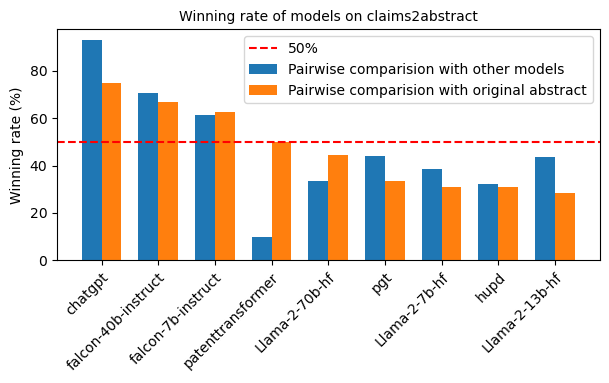

In [6]:
# visualize bar plots of choices_with_models (blue) and choices_with_orig (orange) for each model next to each other
import matplotlib.pyplot as plt
import numpy as np

# Combine the two datasets into a single dataset for sorting
combined_data = sorted(zip(choices_with_models, choices_with_orig), key=lambda x: x[1][1], reverse=True)
choices_with_models_sorted, choices_with_orig_sorted = zip(*combined_data)

# fix size of the plot
plt.figure(figsize=(7, 3))  # Adjust the figure size as needed

model_names, freqs_models = zip(*choices_with_models_sorted)
model_names, freqs_orig = zip(*choices_with_orig_sorted)

width = 0.35  # Width of the bars
bar_positions_models = np.arange(len(model_names))
bar_positions_orig = bar_positions_models + width  # Shift the positions for the second set of bars

plt.bar(bar_positions_models, freqs_models, width=width, label="Pairwise comparision with other models")
plt.bar(bar_positions_orig, freqs_orig, width=width, label="Pairwise comparision with original abstract")

# add red line to 50% for reference
plt.axhline(y=50, color='r', linestyle='--', label="50%")


plt.xticks(bar_positions_models + width / 2, model_names, rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Winning rate (%)")
plt.title("Winning rate of models on claims2abstract", fontsize=10)
plt.legend()

plt.savefig('./figures/c2a_choices_ratio', dpi=300)